# Deep Learning Model Analysis

This notebook contains two sections which analyse the data and models trained in the *model_training.ipynb* notebook:

+ In section [1. Load data and model](#1ma) the data and trained model of the ePodium and the DDP dataset are loaded.
+ In section [2. Make predictions on test set](#2ma) the loaded model is used to make predictions on the test set. The loss of the test set is calculated and the predictions are plotted in a scatterplot.

#### Import Packages
Note: This notebook may output tensorflow errors if cuda is not properly installed. The notebook still functions with these errors.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import ipywidgets
import tensorflow as tf
from IPython.display import clear_output

# Local
import local_paths
from functions import epodium, display_helper
from functions.epodium import Epodium
from functions.ddp import DDP
from functions.sequences import EpodiumSequence, DDPSequence

# Models
from models.dl_4_tsc import encoder_model, fully_convolutional_model, resnet_model
from models.eeg_dl import transformer_model

2022-11-01 23:35:27.030615: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 23:35:27.030653: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



---
<br>

<a id="1ma"></a>
## 1. Load data and model

####  Choose the DDP or ePodium dataset

In [2]:
def choose_dataset(dataset_name):
    global epochs_directory, labels
    if dataset_name == "epodium":
        dataset = Epodium()
    elif dataset_name == "ddp":
        dataset = DDP()
        epochs_directory = local_paths.DDP_epochs
        directory_age_metadata = os.path.join(local_paths.DDP_metadata, "ages")
        labels = dataset.create_labels(local_paths.DDP_dataset, directory_age_metadata)

    print(f"Using dataset: {dataset_name}.")

# Widget settings
dataset_name = ipywidgets.RadioButtons(description='Dataset:', options=["ddp", "epodium"], value="ddp")
ui = ipywidgets.HBox([dataset_name])
out = ipywidgets.interactive_output(choose_dataset, {'dataset_name': dataset_name})
display(ui, out)

Output()

### Load a trained model
Choose from the trained models in the _local_paths.models_ folder.

In [3]:
# Required plot setting:
%matplotlib inline 

# history = []
                                       
def load_model(trained_model):
    try:
        base_path = os.path.join(local_paths.models, trained_model)
    except:
        print("No models found.")
        return
    path_history = os.path.join(base_path, "history.npy")
    path_model = os.path.join(base_path, "model")
    path_testset = os.path.join(base_path, "subsets", "test_set.txt")
    path_weights = os.path.join(base_path, "weights.h5")
    
    global model
    global testset
    global history

    # Load Model
    if(os.path.exists(path_model)):
        print(f"\nLoading Model: '{model_widget.value}'.")

        # Loads the entire model from a folder:
        model = tf.keras.models.load_model(path_model)
        model.load_weights(path_weights)
        # Reads the test-set of the trained model and puts the experiment names into a list:
        testset = open(path_testset, "r").read().split()
        # Loads the training history dictionary:
        history = np.load(path_history, allow_pickle=True).item()
        
        # Show Loss of Training History
        print(f"\nThe lowest validation loss is: {round(min(history['val_loss']), 3)}\n")
        display_helper.show_plot(x=range(len(history['loss'][:])), y=history['loss'][:],  ylim=[0,600000], 
                                 xlabel="epochs", ylabel="validation loss", title="Loss during training")
        display_helper.show_plot(x=range(len(history['loss']))[:], y=history['val_loss'][:], ylim=[0,600000],
                                 xlabel="epochs", ylabel="validation loss", title="Validation loss during training")

    else: 
        print("The model is untrained.")

# Find all models in 'local_paths.models' 
all_trained_models = sorted(f for f in os.listdir(os.path.join(local_paths.models)) if not f.startswith("."))
models_dataset = [m for m in all_trained_models if dataset_name.value in m] 

# Widget for selecting the trained models
model_widget = ipywidgets.RadioButtons(options=models_dataset, description='Models:')
display(model_widget)
out = ipywidgets.interactive_output(load_model, {'trained_model': model_widget})
display(out)

RadioButtons(description='Models:', options=('ddp_encoder_age_26ch_500hz', 'ddp_encoder_age_26ch_500hz_2', 'dd…

Output()

<br>

<a id='2ma'></a>
## 2. Make predictions on test set

The predictions are made by predicting the label of multiple ERPs generated from the same experiment. Each ERP is different, since a random subset of the total number of epochs is used for creating the ERPs.

+ *n_passthroughs* is the number of predictions made from the same experiment. A higher number takes longer to process but is more accurate.

In [4]:
n_passthroughs = 10

results = []
# For each experiment in the test-set
for i, experiment in enumerate(testset):
    test_sequence = DDPSequence([experiment], labels, epochs_directory, batch_size=1, n_instances_per_experiment=n_passthroughs)
    x, y = test_sequence.__getitem__(0)
    
    # Make a prediction with the model.
    real_pred = [y[0], np.squeeze(model.predict(x, verbose=0)).mean()]
    results.append(real_pred)
    
    print(f"{i+1}/{len(testset)} predicted.")
    clear_output(wait=True)
    
results = np.array(results)

105/105 predicted.


#### Calculate test loss

The *Root Mean Square Error* (RMSE) is used to compare the different models

In [5]:
error = np.diff(results)
total_loss = np.square(error)
avg_loss = np.average(total_loss)
np.sqrt(avg_loss)

196.86227941559292

#### Scatterplot results 

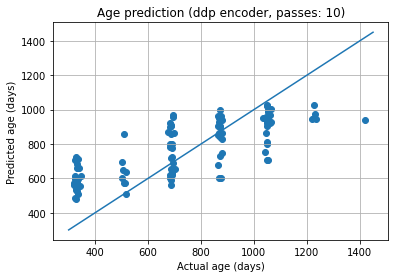

In [6]:
model_info = model_widget.value.split("_")

display_helper.show_plot(np.array(results)[:,0], 
                         np.array(results)[:,1], 
                         f"Age prediction ({model_info[0]} {model_info[1]}, passes: {n_passthroughs})", 
                         "Actual age (days)",
                         "Predicted age (days)",
                         scatter=True,
                         show=False)
plt.grid()
# Line where predicted=actual:
plt.plot([300, 1450], [300, 1450]) 